# Anchor and Counterfactual Explanation

This notebook wil explain about another model to interpret Machine Learning called **Anchor Model**. Different to other models explained before (ALE, SHAP, PDP, PFI, etc.), this model is a local interpretation model to **derive human-interpretable rules** from model interpretation methods. Several keytakeaways you have to understand about Anchor before continuing:

- Aims to identify concise and human-readable **"if-then"** rules that explain why a particular prediction was made. 
- Anchor method perturbs (making small modifications to the input data) instances, generates perturbed data, and derives anchor rules based on these perturbations.
- Thus, it's able to derive a counterfactual expalanation as well.
- Anchor method was **initially developed for classification models**, but its underlying principles and techniques can be adapted and extended to other types of machine learning models, including regression.

The main topics in this activity are:

1. Understanding anchor explanations
2. Exploring counterfactual explanations
3. Comparing with the contrastive explanation method

    Import every library that would be used for this activity

In [6]:
import math
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics

# model that we're going to use, catboost (categorical booster)
# gradient boosting library specifically designed for handling categorical features in machine learning tasks. 

from catboost import CatBoostClassifier
from catboost import Pool

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

# alibi is an open-source Python library that provides various methods interpretability in machine learning
# one of them is to create anchor explainer, using AnchorTabular method

from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
from alibi.explainers import AnchorTabular
from alibi.explainers import CEM
from alibi.explainers import CounterfactualProto  # CounterFactualProto is deprecated

import shap

# Dataset and Cleansing

The data here uses **Mock Email Campaign Data** uploaded by Aristotelis Charalampous. The data are obtained from a hypothetical email campaign by serving 3 different Subject Lines across a three month period. There exist three tables to play around.

- respond.csv (customer who responded to the email)
- sent_emails.csv (emails sent to the customers)
- userbase.csv (user profile - gender, type, email, age, tenure)

For an email to be considered as success (valid responses), the emails should be opened at the sent date (i.e. sent_date should be equal to responded_date).

    Import and read the data

In [7]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/aristotelisch/playground-mock-email-campaign')

Skipping, found downloaded files in "./playground-mock-email-campaign" (use force=True to force download)


In [8]:
df_respond = pd.read_csv('playground-mock-email-campaign/responded.csv')
df_sent = pd.read_csv('playground-mock-email-campaign/sent_emails.csv')
df_user = pd.read_csv('playground-mock-email-campaign/userbase.csv')

In [9]:
df_respond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378208 entries, 0 to 378207
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Responded_Date  378208 non-null  object
 1   Customer_ID     378208 non-null  int64 
 2   SubjectLine_ID  378208 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ MB


In [10]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2476354 entries, 0 to 2476353
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Sent_Date       object
 1   Customer_ID     int64 
 2   SubjectLine_ID  int64 
dtypes: int64(2), object(1)
memory usage: 56.7+ MB


In [11]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Customer_ID    500000 non-null  int64 
 1   Gender         500000 non-null  object
 2   Type           500000 non-null  object
 3   Email_Address  500000 non-null  object
 4   Age            500000 non-null  int64 
 5   Tenure         500000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 22.9+ MB


## Data Cleansing & Transformation

    Drop duplicated data

In [12]:
list_of_df = [df_respond, df_sent, df_user]

for i, df in enumerate(list_of_df):
    print(f'for dataframe number {i}')
    print('-----')
    print(df.duplicated().value_counts())
    
    if i < 2:
        print('\n')
    else:
        pass

for dataframe number 0
-----
False    377848
True        360
dtype: int64


for dataframe number 1
-----
False    2476354
dtype: int64


for dataframe number 2
-----
False    500000
dtype: int64


In [13]:
# drop duplicate from respond data

print('len before dropping duplicates:', len(df_respond))
df_respond = df_respond.drop_duplicates(keep='first')

print('len after dropping duplicates:', len(df_respond))

len before dropping duplicates: 378208
len after dropping duplicates: 377848


    Merging Dataframe

In [14]:
# change column name for date to mail_date
# for merging later

df_sent = df_sent.rename(columns={'Sent_Date': 'mail_date'})
df_respond = df_respond.rename(columns={'Responded_Date': 'mail_date'})

df_respond['respond'] = 1

In [15]:
# merging and coding respond with 1 and non-respond with 0

df = df_sent.merge(df_respond, how='left', on=['Customer_ID', 'SubjectLine_ID', 'mail_date'])
df['respond'] = df['respond'].fillna(0)

In [16]:
df['respond'].value_counts()

0.0    2247545
1.0     228809
Name: respond, dtype: int64

In [17]:
print('length of the dataframe:', len(df))

length of the dataframe: 2476354


In [18]:
# merging the final dataframe

df = df.merge(df_user, how='left', on=['Customer_ID'])
df

,mail_date,Customer_ID,SubjectLine_ID,respond,Gender,Type,Email_Address,Age,Tenure
0,2016-01-28,1413,2,0.0,M,B,Jaj2NuUJneD@gmail.com,44,12
1,2016-03-02,83889,2,0.0,M,C,Y1Se1qBYrUe@hotmail.com,29,23
2,2016-03-09,457832,3,0.0,M,C,vAF@gmail.com,26,14
3,2016-01-20,127772,1,0.0,M,C,QAWqTT@gmail.com,26,15
4,2016-02-03,192123,3,0.0,M,C,Qtgy0C@msn.com,33,9
...,...,...,...,...,...,...,...,...,...
2476349,2016-02-22,460565,3,0.0,M,C,zXC@gmail.com,20,9
2476350,2016-02-25,360823,2,0.0,M,B,RWZCOsi51@yahoo.com,41,15
2476351,2016-03-02,443177,2,0.0,F,C,Gie35rV0W@gmail.com,34,24
2476352,2016-03-12,179200,3,0.0,F,C,9GAWKtezhBeIywHST3@gmail.com,32,17


    Variable Transformation

In [19]:
import datetime

# convert mail_date to pandas datetime
 
df['mail_date'] = pd.to_datetime(df['mail_date']).dt.date

# extract the days from mail date

df['date_day'] = df['mail_date'].apply(lambda d: datetime.datetime.strftime(d, '%A'))
df['date_month'] = df['mail_date'].apply(lambda d: datetime.datetime.strftime(d, '%B'))

In [20]:
# taking the domain of the mail
# seeing whether domain of the email really affect people

df['email_domain'] = df['Email_Address'].apply(lambda x: x.split('@')[1])

In [21]:
df['email_domain'].value_counts()

gmail.com      743771
hotmail.com    621053
msn.com        369992
yahoo.com      320720
aol.com        247943
comcast.net    172875
Name: email_domain, dtype: int64

In [22]:
# final dataframe print

df

,mail_date,Customer_ID,SubjectLine_ID,respond,Gender,Type,Email_Address,Age,Tenure,date_day,date_month,email_domain
0,2016-01-28,1413,2,0.0,M,B,Jaj2NuUJneD@gmail.com,44,12,Thursday,January,gmail.com
1,2016-03-02,83889,2,0.0,M,C,Y1Se1qBYrUe@hotmail.com,29,23,Wednesday,March,hotmail.com
2,2016-03-09,457832,3,0.0,M,C,vAF@gmail.com,26,14,Wednesday,March,gmail.com
3,2016-01-20,127772,1,0.0,M,C,QAWqTT@gmail.com,26,15,Wednesday,January,gmail.com
4,2016-02-03,192123,3,0.0,M,C,Qtgy0C@msn.com,33,9,Wednesday,February,msn.com
...,...,...,...,...,...,...,...,...,...,...,...,...
2476349,2016-02-22,460565,3,0.0,M,C,zXC@gmail.com,20,9,Monday,February,gmail.com
2476350,2016-02-25,360823,2,0.0,M,B,RWZCOsi51@yahoo.com,41,15,Thursday,February,yahoo.com
2476351,2016-03-02,443177,2,0.0,F,C,Gie35rV0W@gmail.com,34,24,Wednesday,March,gmail.com
2476352,2016-03-12,179200,3,0.0,F,C,9GAWKtezhBeIywHST3@gmail.com,32,17,Saturday,March,gmail.com


# Data Preparation and Model Training

    Data Inspection for Imbalance in the Response

In [23]:
df['respond'].value_counts()

0.0    2247545
1.0     228809
Name: respond, dtype: int64

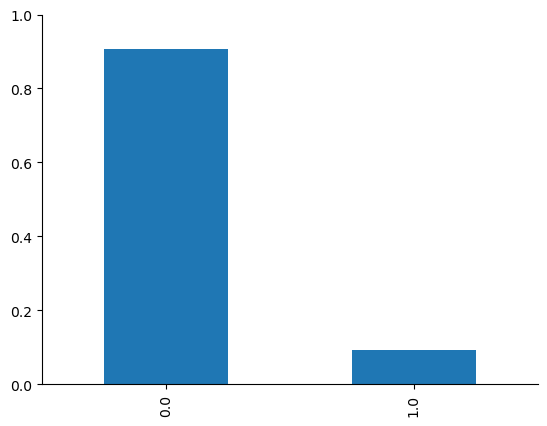

In [24]:
df['respond'].value_counts(normalize=True).plot(kind='bar', ylim=(0,1))
sns.despine()

    Warning! There's a Class Imbalance

If we have this, there are 2 things we can do, which are:

1. Random Under-sampling: Removing some observations of the majority class
2. Random Over-sampling: Adding more copies to the minority class

### Random Under-sampling Using Imblearn

In [25]:
# set random seed

rand = 9
np.random.seed(rand)
tf.random.set_seed(rand)

In [26]:
# define x and y variable for the model

y = df['respond']
x = df.drop(['mail_date', 'Customer_ID', 'Email_Address', 'respond'], axis=1)

In [27]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)  # fit predictor and target variable
x_rus, y_rus = rus.fit_resample(x, y)

print('original dataset shape:', len(y))
print('Resample dataset shape', len(y_rus))

original dataset shape: 2476354
Resample dataset shape 457618


In [28]:
y_rus.value_counts()

0.0    228809
1.0    228809
Name: respond, dtype: int64

For more additional information about how to tackle the problem of imbalance dataset, see this:
- Documentation for Imbalance Learned: https://imbalanced-learn.org/stable/
- Collection on How to Do It and it's Tutorial: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

    Train-Test Split

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.2, random_state=rand)

In [30]:
x_train

,SubjectLine_ID,Gender,Type,Age,Tenure,date_day,date_month,email_domain
264300,3,F,B,34,8,Monday,February,msn.com
125285,2,F,C,30,23,Tuesday,January,hotmail.com
126918,2,F,C,33,14,Friday,February,yahoo.com
215133,3,M,C,29,14,Saturday,March,gmail.com
105206,3,M,C,32,12,Tuesday,January,msn.com
...,...,...,...,...,...,...,...,...
173819,1,M,C,22,24,Monday,February,yahoo.com
415800,3,F,C,25,28,Friday,February,hotmail.com
196534,1,F,C,31,15,Thursday,January,msn.com
187006,1,M,B,34,9,Thursday,January,gmail.com


## Model Training: CatBoost Classifier

- CatBoostClassifier can encode categorical variables directly without creating a preprocessing pipeline
- Specify the **cat_features** parameter by the indices of the categorical features in our training dataset

In [31]:
# fitting the model

cat_feature_indices = [1, 2, 5, 6, 7]

cb_mdl = CatBoostClassifier(iterations=500,
                            learning_rate=0.5,
                            depth=8,
                            cat_features=cat_feature_indices  # pass the categorical feature indices here
                            )  

fitted_cb_mdl = cb_mdl.fit(x_train, y_train, verbose=False)

In [32]:
# evaluate the model
# there's a method we can use from the catboost model itself

from catboost import Pool

test_pool = Pool(data=x_test, 
                 label=y_test, 
                 cat_features=cat_feature_indices)

eval_metrics = fitted_cb_mdl.eval_metrics(data=test_pool, 
                                          metrics=['Accuracy', 'AUC']
                                          )

# the way to read the eval metrics is different
# it's based on every data point evaluation, 1 and 0

print(eval_metrics)

{'Accuracy': [0.527348018006206, 0.5265176347187623, 0.5274682050609676, 0.5268781958830471, 0.5275119094445173, 0.5272496831432193, 0.5273589441020934, 0.527348018006206, 0.5270748656090206, 0.5272496831432193, 0.5274026484856431, 0.5273370919103186, 0.5273370919103186, 0.5273370919103186, 0.52716227437612, 0.5264957825269875, 0.5266487478694113, 0.526692452252961, 0.5266268956776364, 0.5267689349241729, 0.5267798610200604, 0.5263865215681133, 0.5263209649927888, 0.5265176347187623, 0.5267033783488484, 0.5263865215681133, 0.5265504130064246, 0.5261242952668153, 0.5261352213627026, 0.5259385516367292, 0.5262663345133517, 0.5256981775272059, 0.5250426117739609, 0.5253376163629212, 0.525097242253398, 0.5254578034176828, 0.5248787203356496, 0.5244526025960404, 0.5241138936235304, 0.5241794501988549, 0.5243324155412787, 0.5237205541715834, 0.5237205541715834, 0.5238188890345702, 0.5238625934181198, 0.5237314802674709, 0.524703902801451, 0.5244307504042656, 0.5245509374590271, 0.52449630697

In [33]:
# evaluate the model conventionally

y_train_cb_pred = fitted_cb_mdl.predict(x_train)
y_test_cb_pred = fitted_cb_mdl.predict(x_test)

rmse_cb_train = metrics.mean_squared_error(y_train,
                                           y_train_cb_pred,
                                           squared=False)

rmse_cb_test = metrics.mean_squared_error(y_test,
                                          y_test_cb_pred,
                                          squared=False)

r2_cb_test = metrics.r2_score(y_test, y_test_cb_pred)

print('All the score of RMSE train, test, and R2 score:', rmse_cb_train, ',', rmse_cb_test, ',', r2_cb_test)

All the score of RMSE train, test, and R2 score: 0.6564465803856134 , 0.6923666160095789 , -0.917488599737611


    Evaluating Data Using ROC-AUC

- ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes
- Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.
- It considers true positive rate (sensitivity) and false positive rate (1 - specificity) across various threshold values, providing a more comprehensive understanding of the model's performance.
- AUC-ROC is a good choice for evaluating classification models on imbalanced datasets because it provides a robust and threshold-independent measure of the model's ability to discriminate between classes.

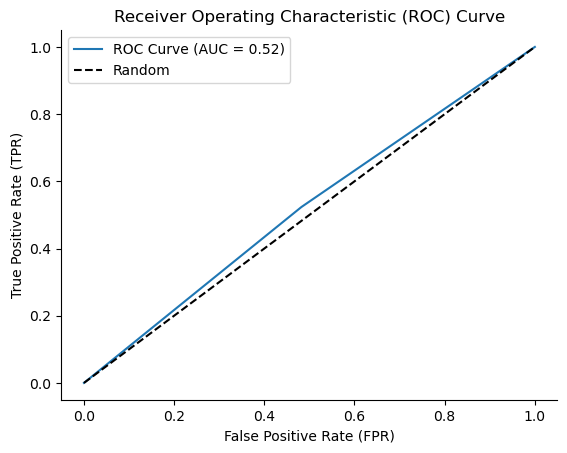

In [34]:
# evaluate the model using roc-auc curve
# it's a plot between false positive rate to true positive rate

# calculate the false positive rate (FPR), true positive rate (TPR), and classification thresholds

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_cb_pred)

# calculate the area under the ROC curve (AUC)

auc = metrics.roc_auc_score(y_test, y_test_cb_pred)

# plotting the roc curve

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

sns.despine()

plt.show()

## Model Training: Neural Network Model

In [35]:
# preprocess all the data first

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

to_transform = [a for a in x.columns if x[a].dtype == 'object']

# one hot encoding for the 'object' column in the dataframe
# while we're going to pass the remainder

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), to_transform),
    remainder='passthrough'
    )

# fit-transform the x_train and x_test

x_train_trf = transformer.fit_transform(x_train)
x_test_trf = transformer.transform(x_test)

x_cols = transformer.get_feature_names_out()

# convert to data frame as the original data is in array data type

x_train_trf = pd.DataFrame(x_train_trf, columns=x_cols)
x_test_trf = pd.DataFrame(x_test_trf, columns=x_cols)

display(x_train_trf.sample(5))
display(x_test_trf.sample(5))

,onehotencoder__Gender_F,onehotencoder__Gender_M,onehotencoder__Type_B,onehotencoder__Type_C,onehotencoder__date_day_Friday,onehotencoder__date_day_Monday,onehotencoder__date_day_Saturday,onehotencoder__date_day_Sunday,onehotencoder__date_day_Thursday,onehotencoder__date_day_Tuesday,...,onehotencoder__date_month_March,onehotencoder__email_domain_aol.com,onehotencoder__email_domain_comcast.net,onehotencoder__email_domain_gmail.com,onehotencoder__email_domain_hotmail.com,onehotencoder__email_domain_msn.com,onehotencoder__email_domain_yahoo.com,remainder__SubjectLine_ID,remainder__Age,remainder__Tenure
213546,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,32.0,24.0
260343,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,33.0,11.0
209883,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,31.0,13.0
113194,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,33.0,24.0
308375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,32.0,5.0


,onehotencoder__Gender_F,onehotencoder__Gender_M,onehotencoder__Type_B,onehotencoder__Type_C,onehotencoder__date_day_Friday,onehotencoder__date_day_Monday,onehotencoder__date_day_Saturday,onehotencoder__date_day_Sunday,onehotencoder__date_day_Thursday,onehotencoder__date_day_Tuesday,...,onehotencoder__date_month_March,onehotencoder__email_domain_aol.com,onehotencoder__email_domain_comcast.net,onehotencoder__email_domain_gmail.com,onehotencoder__email_domain_hotmail.com,onehotencoder__email_domain_msn.com,onehotencoder__email_domain_yahoo.com,remainder__SubjectLine_ID,remainder__Age,remainder__Tenure
62164,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,37.0,25.0
159,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,39.0,25.0
87027,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,12.0
77597,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,32.0,26.0
55970,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,28.0,25.0


    Warning!

- Starting in TensorFlow version 2, eager execution enabled by default. 
- This is not compatible with tf.placeholder(), the process in the back-end for CounterfactualProto. 
- Thus, we have to disable it

In [36]:
# disable eager execution

tf.compat.v1.disable_eager_execution()

In [37]:
# fit and train the model

fitted_nn_mdl = tf.keras.Sequential([
    tf.keras.Input(shape=[len(x_train_trf.keys())]),
    layers.Dense(7, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

fitted_nn_mdl.compile(loss='mean_squared_error',
                      optimizer='adam')

nn_history = fitted_nn_mdl.fit(x_train_trf.values,
                               y_train.values,
                               epochs=12,
                               batch_size=32,
                               validation_split=0.2,
                               verbose=0)

2023-07-04 07:48:09.849365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-07-04 07:48:09.891914: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense/bias/v/Assign' id:203 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-07-04 07:48:12.101109: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:68 op device:{requested: '', assigned: '

In [38]:
# evaluate the model conventionally
# the prediction score here is shown in probability instead of prediction directly...
# ...like catboost does to the previous model

y_train_nn_pred = fitted_nn_mdl.predict(x_train_trf)
y_test_nn_pred = fitted_nn_mdl.predict(x_test_trf)

rmse_nn_train = metrics.mean_squared_error(y_train,
                                           y_train_nn_pred,
                                           squared=False)

rmse_nn_test = metrics.mean_squared_error(y_test,
                                          y_test_nn_pred,
                                          squared=False)

r2_nn_test = metrics.r2_score(y_test, y_test_nn_pred)

print('All the score of RMSE train, test, and R2 score:', rmse_cb_train, ',', rmse_cb_test, ',', r2_nn_test)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-07-04 07:48:38.981753: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Sigmoid' id:50 op device:{requested: '', assigned: ''} def:{{{node dense_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


All the score of RMSE train, test, and R2 score: 0.6564465803856134 , 0.6923666160095789 , 0.003662513569424153


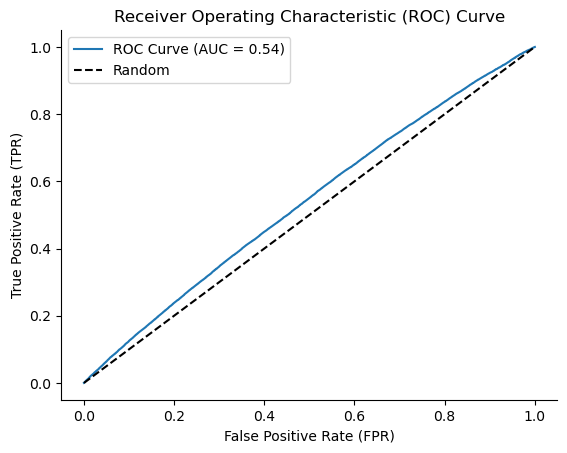

In [39]:
# evaluate the model using roc-auc curve
# it's a plot between false positive rate to true positive rate

# calculate the false positive rate (FPR), true positive rate (TPR), and classification thresholds

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_nn_pred)

# calculate the area under the ROC curve (AUC)

auc = metrics.roc_auc_score(y_test, y_test_nn_pred)

# plotting the roc curve

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

sns.despine()

plt.show()

# Anchor Explanations

A model to explain Machine Learning model with pertubration-based (changing the x-value of the instance to see the difference it makes) strategy. The mechanism works like this:

1. Sampling: Anchor selects a subset of instances that are similar to the prediction to be explained.

2. Rule Generation: It then creates a binary decision tree using the selected instances, where each path from the root to a leaf represents a rule. Rules are typically defined in terms of feature thresholds and logical conditions.

3. Rule Evaluation: Anchor evaluates the rules using a metric such as precision, which measures the coverage of the rule and the proportion of correct predictions it captures.

4. Interpretation: The final output of Anchor is a small set of interpretable rules that accurately describe the model's predictions.

    Data Preparation for Human-like Interpretation

In [40]:
cat_feature_indices = [1, 2, 5, 6, 7]

In [41]:
# 1. defining the class name first
# as our response at the moment is 0 and 1

class_names = ['did not respond', 'responded']

# 2. defining which one is our categorical variable
# alibi has the ability to convert categorical to ordinal variable
# the syntax is dictionary where -> {(key = index of cat var): (number of categories)}

cat_vars_ohe = {1:2, 2:2, 5:7, 6:3, 7:6}

# 3. create a category map
# alibi will need a dictionary that provides names for each category and a list of feature names

# cat map and feature names for catboost

cat_map = {
    1: ['Female', 'Male'],
    2: ['Business', 'Consumer'],
    5: ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
    6: ['February', 'January', 'March'],
    7: ['aol.com', 'comcast.net', 'gmail.com', 'hotmail.com', 'msn.com', 'yahoo.com']
}

feat_names_cb = fitted_cb_mdl.feature_names_

# cat map for neural network model

cat_map_ohe = {
    1: ['Not Female', 'Female'],
    2: ['Not Male', 'Male'],
    3: ['Not Business', 'Business'],
    4: ['Not Consumer', 'Consumer'],
    4: ['Not Friday', 'Friday'],
    5: ['Not Monday', 'Monday'],
    6: ['Not Saturday', 'Saturday'],
    7: ['Not Sunday', 'Sunday'],
    8: ['Not Thursday', 'Thursday'],
    9: ['Not Tuesday', 'Tuesday'],
    10: ['Not Wednesday', 'Wednesday'],
    11: ['Not February', 'February'],
    12: ['Not January', 'January'],
    13: ['Not March', 'March'],
    14: ['Not AOL', 'AOL'],
    15: ['Not Comcast', 'Comcast'],
    16: ['Not Gmail', 'Gmail'],
    17: ['Not Hotmail', 'Hotmail'],
    18: ['Not MSN', 'MSN'],
    19: ['Not Yahoo', 'Yahoo'],
}

feat_names_nn = x_train_trf.columns

## Local Interpration for Anchor Explanations

    For CatBoost Model

Should investigate more for CatBoost model as it failed to call the predictor on the data. Documentation about the error:

- Predictor failed to be called on  of shape (1, 23) and dtype float32. Check that the parameter `feature_names` is correctly specified
- There might be a conflict between internal of CatBoost model and the feature names that we have to pass to AnchorTabular
- Because the data passed to CatBoost model is the original data, not the one after encoding as CatBoost can handle the categorical data automatically without converting the data first

In [42]:
predict_cb_fn = lambda x: np.float32(fitted_cb_mdl.predict_proba(x))

anchor_cb_explainer = AnchorTabular(predict_cb_fn,
                                    x_train_trf.columns,
                                    categorical_names=cat_map)

anchor_cb_explainer.fit(x_train.values)

PredictorCallError: Predictor failed to be called on <class 'numpy.ndarray'> of shape (1, 23) and dtype float32. Check that the parameter `feature_names` is correctly specified.

    For Neural Network Model

In [43]:
# make a wrapper for prediction probability
# should include the probability for 0 and 1

predict_nn_fn = lambda x: np.concatenate((1 - fitted_nn_mdl.predict(x), fitted_nn_mdl.predict(x)), axis=1)

# pass the wrapper to AnchorTabular first
# with the feature names
# and categorical names, defined before

anchor_nn_explainer = AnchorTabular(predict_nn_fn,
                                    feature_names=x_train_trf.columns,
                                    categorical_names=cat_map_ohe)

# fit it to the training data
# using the x_train data, not x_test

anchor_nn_explainer.fit(x_train_trf.values)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.3'}
)

In [44]:
# specify the index from the data that we want to check
# using the test data, not the training

idx_to_check = np.random.choice(x_test_trf.index)

# pass it to anchor_nn_explainer.explain() 

anchor_nn_explanation = anchor_nn_explainer.explain(x_test_trf.loc[idx_to_check].values,
                                                    threshold=0.85,
                                                    seed=rand)

There are two variables we can see from here to **evaluate the Anchor performance**:

- **Precision:** Precision measures the proportion of instances in which the anchor's prediction is true among all instances where the anchor is applicable. In other words, it assesses how well the anchor explanation aligns with the model's behavior. A higher precision indicates that the anchor is a more reliable explanation for the model's prediction.
- **Coverage:** Coverage represents the proportion of instances for which the anchor is applicable among all instances in the dataset. It indicates the scope or reach of the anchor explanation. Higher coverage suggests that the anchor is applicable to a larger portion of the data, making it more comprehensive.

Precision and coverage are typically trade-offs in anchor explanations. Increasing precision often leads to lower coverage, and vice versa. A highly precise anchor might only cover a subset of instances, while a more general anchor with broader coverage may have lower precision. The goal is to strike a balance between precision and coverage based on the specific requirements of the explanation task.

In [45]:
# print every important variable

print('Index checked: %s' % idx_to_check)
print('Prediction score %.3f' % fitted_nn_mdl.predict(x_train_trf.loc[[idx_to_check]]))
print('Anchor: %s' % (' AND '.join(anchor_nn_explanation.anchor)))

print('Precision: %.3f' % anchor_nn_explanation.precision)
print('Coverage: %.3f' % anchor_nn_explanation.coverage)

Index checked: 86585
Prediction score 0.548
Anchor: remainder__SubjectLine_ID <= 1.00 AND onehotencoder__Gender_M = Not Female
Precision: 0.984
Coverage: 0.117


# Counterfactual Explanation

***"What would happen if we do A instead of B?"***

Counterfactual explanation is a human-friendly exlanations where we can explain outcomes in terms of what would need to change to get the opposite outcome (the **counterfactual class**).

The algorithm does the following:

1. Select an instance and define the desired outcome (counterfactual).
2. Leverage **loss function** that helps finding the counterfactuals closest to our instance of interest.
3. Changing as few features as possible (**perturbation**).
4. Even though the features don't have to be real points, they have to be in realistic distribution.
5. Run fast enough to be useful in real-world scenario.

## Counterfactuals Guided by Prototypes (CounterFactualProto in Alibi Library)

    Define the feature range first

In [46]:
# as explained before, the distribution has to be realistic

feature_range = (x_train_trf.values.min(axis=0).reshape(1,23).astype(np.float32),
                 x_train_trf.values.max(axis=0).reshape(1,23).astype(np.float32)
                 )

feature_range

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 18.,  0.]], dtype=float32),
 array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  3., 62., 38.]], dtype=float32))

    Fit Our Counterfactual Explainer

In [47]:
# CounterfactualProto documentation
# What are the parameters to pass?

from alibi.explainers import CounterfactualProto

?CounterfactualProto

Init signature:
CounterfactualProto(
    predict: Union[Callable[[numpy.ndarray], numpy.ndarray], keras.src.engine.training.Model],
    shape: tuple,
    kappa: float = 0.0,
    beta: float = 0.1,
    feature_range: Tuple[Union[float, numpy.ndarray], Union[float, numpy.ndarray]] = (-10000000000.0, 10000000000.0),
    gamma: float = 0.0,
    ae_model: Optional[keras.src.engine.training.Model] = None,
    enc_model: Optional[keras.src.engine.training.Model] = None,
    theta: float = 0.0,
    cat_vars: Optional[Dict[int, int]] = None,
    ohe: bool = False,
    use_kdtree: bool = False,
    learning_rate_init: float = 0.01,
    max_iterations: int = 1000,
    c_init: float = 10.0,
    c_steps: int = 10,
    eps: tuple = (0.001, 0.001),
    clip: tuple = (-1000.0, 1000.0),
    update_num_grad: int = 1,
    write_dir: Optional[str] = None,
    sess: Optional[tensorflow.python.client.session.Session] = None,
) -> None
Docstring:      Base class for explainer algorithms from :py:mod:`alibi.e

In [48]:
# define the instance we want to investigate

idx_to_check = np.random.choice(x_test_trf.index)
x_test_eval = x_test_trf.loc[[idx_to_check]].values
y_test_eval = y_test.reset_index(drop=True).loc[[idx_to_check]].values

print('index for:', idx_to_check)
print('prediction probability:', fitted_nn_mdl.predict(x_test_eval))
print('actual data:', y_test_eval)

print('----')
print('actual data of x:', x_test_eval)

index for: 18598
prediction probability: [[0.5092686]]
actual data: [0.]
----
actual data of x: [[ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.
   0.  0.  2. 24. 26.]]


In [49]:
# make a wrapper for prediction probability
# should include the probability for 0 and 1

predict_nn_fn = lambda x: np.concatenate((1 - fitted_nn_mdl.predict(x), fitted_nn_mdl.predict(x)), axis=1)

# initiate the explainer of CounterFactualProto

cf_nn_explainer = CounterfactualProto(predict=predict_nn_fn,
                                      shape=x_test_eval.shape,  # fit to the point of the data we want to evaluate
                                      max_iterations=100,
                                      feature_range=feature_range,
                                      beta=0.1,
                                      theta=5,
                                      use_kdtree=True
                                      )

cf_nn_explainer.fit(x_test_trf.values, d_type='abdm-mvdm')

No encoder specified. Using k-d trees to represent class prototypes.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.1,
              'gamma': 0.0,
              'theta': 5,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 100,
              'c_init': 10.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'feature_range': (array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 18.,  0.]], dtype=float32), array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  3., 62., 38.]], dtype=float32)),
              'shape': (1, 23),

    Evaluate and investigate the result of Counterfactual explainer

In [50]:
# print the counterfactual explanation
# focus on X variable from cf_nn_explanation.cf

cf_nn_explanation = cf_nn_explainer.explain(x_test_eval)
cf_nn_explanation.cf

{'X': array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 9.2685282e-01,
         0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.0000000e+00, 0.0000000e+00, 1.3152435e-03, 1.4548925e-01,
         9.0313512e-01, 0.0000000e+00, 0.0000000e+00, 1.8002895e-01,
         2.0748730e+00, 2.4000000e+01, 2.6000000e+01]], dtype=float32),
 'class': 0,
 'proba': array([[0.50035614, 0.49964386]], dtype=float32),
 'grads_graph': array([[ 0.       ,  0.       ,  0.       , -2.2016888,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       , -0.410805 ,  0.       ,  1.2882946,
          3.1215682, -2.5032754,  0.       ,  0.       ,  3.5607648,
         -8.372787 ,  0.       ,  0.       ]], dtype=float32),
 'grads_num': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]])}

In [51]:
# compare it to our actual x and y
# act for actual
# cf for counterfactual

pd.DataFrame(data=[x_test_eval[0], np.round(cf_nn_explanation.cf['X'][0], 1)], 
             columns=x_cols,
             index=['act', 'cf']).T

,act,cf
onehotencoder__Gender_F,0.0,0.0
onehotencoder__Gender_M,1.0,1.0
onehotencoder__Type_B,0.0,0.0
onehotencoder__Type_C,1.0,0.9
onehotencoder__date_day_Friday,0.0,0.0
onehotencoder__date_day_Monday,0.0,0.0
onehotencoder__date_day_Saturday,1.0,1.0
onehotencoder__date_day_Sunday,0.0,0.0
onehotencoder__date_day_Thursday,0.0,0.0
onehotencoder__date_day_Tuesday,0.0,0.0


## Counterfactuals with What-If Tool (WIT) by Google Developer

Requires only few inputs, preparation, and showing the result in an interactive dashboard which are:

- **Datapoint editor**: Visualize datapoints, edit, and explain the predictions
- **Performance**: Model performance metrics (high-level)
- **Features**: General feature statistics

In [61]:
# wit stands for what-if tool, interactive visual interface for better understanding of models by exploring "what-if" scenarios
# can be used with various machine learning frameworks, including tensorflow, scikit-learn, and xgboost.

import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

    Warning!

- Previously, we disable eager_execution from tensorflow 2 using tf.compat.v1.disable_eager_execution()
- Somehow, it also remove the 'keras.saving.hdf5_format' from the module
- Thus, we cannot initiate the shap.TreeExplainer for later to be passed to wit
- Have to set up a new environment again for this one
- See more from **PAGE 308** to learn more about the implementation of WIT

## Contrastive Explanation Method (CEM)

Like the previous models, CEM is a technique that aims to provide explanations for individual predictions by contrasting them with alternative outcomes. It generates explanations by highlighting the differences between the features of the predicted instance and those of alternative instances that could have led to a different prediction. CEM focuses on identifying the minimal set of features necessary to explain the prediction change.

The differences to CounterfactualProto model are:

- CEM focuses on explaining the decision-making process of the model by contrasting different instances and identifying the key factors contributing to the prediction change.
- CounterfactualProto generates alternative instances or scenarios to understand the changes required in the input features to achieve a specific prediction while holding other factors constant.

    The way it works...

Different to CounterFactualProto, CEM doesn't fall back on k-d trees, so there's an optional of using **autoencoder** to make explanations more realistic when the dataset is relatively small or noisy.

Why using autoencoder?

1. **Data Compression and Feature Extraction:**

An autoencoder can compress the input data into a lower-dimensional representation, often called the "bottleneck" layer. This compression process helps in extracting the most important features or patterns from the data. By reducing the dimensionality, the autoencoder aims to capture the essential information needed for explaining the model's decision.

2. **Noise Reduction and Reconstruction:**

The autoencoder's reconstruction process can act as a denoising mechanism. It learns to reconstruct the input data from its compressed representation, which effectively filters out noisy or irrelevant features. By reconstructing the data, the autoencoder provides a cleaner and more focused representation of the input, which can aid in generating clearer explanations.

3. **Explanation Generation:**

In CEM, explanations are derived by contrasting different instances and identifying the key features that influence the model's decision. By using an autoencoder, the dimensionality-reduced representation obtained from the encoder can serve as a more informative and focused input for generating contrastive explanations. The compressed representation captures the most salient features, making it easier to identify the contrasting features between instances.

    What is Autoencoder?

An autoencoder is like a special type of neural network with an hourglass shape. It has an input layer, an output layer, and some hidden layers in between. The important parts are the encoder and decoder. The encoder takes the input data and makes a simplified version of it, while the decoder tries to recreate the original input from this simplified version. The place where the encoder and decoder meet is called the "bottleneck" layer.

**Objective:**

The goal of training an autoencoder is to make the output of the network match the input data. It tries to learn a **compact representation of the input data** in the bottleneck layer so that when it reconstructs the data, it looks very similar to the original input. By compressing and then reconstructing the data, the **autoencoder can capture important patterns and remove unnecessary details**.

**Training Process:**

During training, the autoencoder adjusts its internal parameters (weights and biases) to minimize the difference between the input and output data. It does this by repeatedly showing the network the input data and comparing the reconstructed output with the original input. It learns from the mistakes it makes and gradually improves its ability to compress and reconstruct the data.

The encoder learns to convert the input data into a simplified representation in the bottleneck layer, reducing the dimensionality of the data. The decoder then tries to recreate the original data from this simplified representation.

In simpler terms, an autoencoder is a special neural network that learns to compress data into a simplified form and then recreate the original data from that simplified form. It does this by training on examples and adjusting its internal parameters. The goal is to capture important patterns and reduce unnecessary details in the data.

So, the flow of the Neural Network would be like:

### **Input layer -> Encoder -> Bottleneck -> Decoder -> Output Layer**

In [69]:
# create input, encoder, bottleneck, decoder, and output layer for neural network model

input_layer = tf.keras.Input(shape=(x_train_trf.shape[1]))

encoder = tf.keras.layers.Dense(10, activation='relu')(input_layer)
bottleneck = tf.keras.layers.Dense(3, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(10, activation='relu')(bottleneck)

output_layer = tf.keras.layers.Dense(x_train_trf.shape[1], activation='linear')(decoder)

# build the neural network model
# and check the summary of the model

autoencoder_mdl = tf.keras.Model(input_layer, output_layer)
autoencoder_mdl.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_7 (Dense)             (None, 10)                240       
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
 dense_9 (Dense)             (None, 10)                40        
                                                                 
 dense_10 (Dense)            (None, 23)                253       
                                                                 
Total params: 566 (2.21 KB)
Trainable params: 566 (2.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
# compiling and fitting the autoencoder

autoencoder_mdl.compile(loss='mean_squared_error',
                        optimizer='adam'
                        )

# pass x and y parameter with x_train value
# as the goal is to produce something that's as close as possible to what went in

autoencoder_history = autoencoder_mdl.fit(x_train_trf.values,  # y and x are the same
                                          x_train_trf.values,
                                          epochs=16,
                                          batch_size=32,
                                          validation_split=0.2,
                                          verbose=0)

2023-07-04 08:41:32.869159: W tensorflow/c/c_api.cc:304] Operation '{name:'training_3/Adam/dense_10/bias/m/Assign' id:904 op device:{requested: '', assigned: ''} def:{{{node training_3/Adam/dense_10/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_3/Adam/dense_10/bias/m, training_3/Adam/dense_10/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-07-04 08:41:36.339860: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:754 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dens

    Predicting the Pertinent Negatives

Pertinent negatives (an agreed term used in explainable machine learning), are instances or features that are identified as relevant but contribute negatively to a specific prediction. These factors, when absent or decreased, tend to support or increase the likelihood of a different outcome or class label being predicted. Recognizing pertinent negatives helps in understanding which elements or characteristics are crucial for the model to avoid making certain predictions.

In [75]:
from alibi.explainers import CEM

# create the model instance

cem_nn_explainer_pn = CEM(predict_nn_fn,
                          'PN',
                          x_test_eval.shape,
                          feature_range=feature_range,
                          gamma=100,
                          max_iterations=100,
                          ae_model=autoencoder_mdl)

# and fit it to our data

cem_nn_explainer_pn.fit(x_train_trf.values,  # train on our training dataset first
                        no_info_type='median')

CEM(meta={
  'name': 'CEM',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'mode': 'PN',
              'shape': (1, 23),
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 18.,  0.]], dtype=float32), array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  3., 62., 38.]], dtype=float32)),
              'gamma': 100,
              'learning_rate_init': 0.01,
              'max_iterations': 100,
              'c_init': 10.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-100.0, 100.0),
              'update_num_grad': 1,
              'no_info_val': None,
              'write_dir': None,
              'is_model': False,
              'is_ae': True,
              'no_info_type'

In [76]:
# create the explanation instance for PN
# and save it to cem_nn_explanation_pn
# will contain all the data we need for CEM inference

cem_nn_explanation_pn = cem_nn_explainer_pn.explain(x_test_eval,  # then we can pass our data here after fitting to training data
                                                    verbose=False)  

In [87]:
# print the x pred

class_names[cem_nn_explanation_pn.X_pred]

'responded'

In [89]:
# pn for the instance of interest

class_names[cem_nn_explanation_pn.PN_pred]

'did not respond'

In [126]:
# prediction probability
# in order, probability of not responding to the email (0), and responding (1)
# slight difference to the positive probability, which is 50.04%

predict_nn_fn(cem_nn_explanation_pn.PN)

array([[0.50042605, 0.49957398]], dtype=float32)

In [84]:
# values of the features

cem_nn_explanation_pn.PN[0]

array([0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 8.1519330e-01,
       0.0000000e+00, 3.8567655e-02, 1.0000000e+00, 6.4078756e-02,
       9.0700082e-02, 3.8130067e-02, 5.6707047e-02, 2.1600351e-03,
       1.0000000e+00, 0.0000000e+00, 1.1654442e-01, 1.8635666e-01,
       1.0000000e+00, 0.0000000e+00, 4.8004337e-02, 1.6208693e-01,
       2.0062368e+00, 2.4000000e+01, 2.6000000e+01], dtype=float32)

    Pertinent Positive

Pertinent positives on the other hand refer to instances or features that are found to be relevant and contribute positively to a specific prediction made by a model. In other words, they are the factors or conditions that are present or increased in instances where the model predicts a specific outcome or class label. Pertinent positives are the features that support or are associated with the desired prediction.

In [91]:
from alibi.explainers import CEM

cem_nn_explainer_pp = CEM(predict_nn_fn,
                          'PP',
                          x_test_eval.shape,
                          feature_range=feature_range,
                          gamma=100,
                          max_iterations=100,
                          ae_model=autoencoder_mdl)

cem_nn_explainer_pp.fit(x_train_trf.values, 
                        no_info_type='median')

CEM(meta={
  'name': 'CEM',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'mode': 'PP',
              'shape': (1, 23),
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 18.,  0.]], dtype=float32), array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  3., 62., 38.]], dtype=float32)),
              'gamma': 100,
              'learning_rate_init': 0.01,
              'max_iterations': 100,
              'c_init': 10.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-100.0, 100.0),
              'update_num_grad': 1,
              'no_info_val': None,
              'write_dir': None,
              'is_model': False,
              'is_ae': True,
              'no_info_type'

In [92]:
# create the explanation instance
# and save it to cem_nn_explanation_pp
# will contain all the data we need for CEM inference

cem_nn_explanation_pp = cem_nn_explainer_pp.explain(x_test_eval, verbose=False)

In [93]:
# print the x pred

class_names[cem_nn_explanation_pp.X_pred]

'responded'

In [94]:
# p for the instance of interest

class_names[cem_nn_explanation_pp.PP_pred]

'responded'

In [120]:
# prediction probability
# in order, probability of not responding to the email (0), and responding (1)

predict_nn_fn(cem_nn_explanation_pp.PP)

array([[0.45681345, 0.54318655]], dtype=float32)

In [95]:
# values of the features

cem_nn_explanation_pp.PP[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.13529968])

    Combine into One Dataframe to Examine Deeper

In [119]:
salient_df = pd.DataFrame({'Feature': x_test_trf.columns,
                           'x': cem_nn_explanation_pn.X[0],
                           'PN': cem_nn_explanation_pn.PN[0],
                           'PN - x': cem_nn_explanation_pn.PN[0] - cem_nn_explanation_pn.X[0],  # columns for what missing from x
                           'PP': cem_nn_explanation_pp.PP[0]}
                           ) 

salient_df = salient_df[(salient_df['PP'] != 0) |
                        (salient_df['PN'] != 0)]

salient_df.sort_values('PN - x', ascending=False)

,Feature,x,PN,PN - x,PP
15,onehotencoder__email_domain_comcast.net,0.0,0.186357,0.186357,0.0000
19,onehotencoder__email_domain_yahoo.com,0.0,0.162087,0.162087,0.0000
14,onehotencoder__email_domain_aol.com,0.0,0.116544,0.116544,0.0000
8,onehotencoder__date_day_Thursday,0.0,0.090700,0.090700,0.0000
7,onehotencoder__date_day_Sunday,0.0,0.064079,0.064079,0.0000
10,onehotencoder__date_day_Wednesday,0.0,0.056707,0.056707,0.0000
18,onehotencoder__email_domain_msn.com,0.0,0.048004,0.048004,0.0000
5,onehotencoder__date_day_Monday,0.0,0.038568,0.038568,0.0000
9,onehotencoder__date_day_Tuesday,0.0,0.038130,0.038130,0.0000
20,remainder__SubjectLine_ID,2.0,2.006237,0.006237,0.0000


    The way to interpret...

Here, we can interpret from PN - x column, which we can interpret as we would a counterfactual, but the attention is giving to what's missing. Here, the **domain email of comcast.net, yahoo.com, and aol.com determine the decision of our instance of interest (x_eval), and it contributes negatively, meaning that if this instance of interest uses comcast, yahoo, or aol, it will make this instance of interest doesn't respond to the email (0).** But, there are some things that need to be understood from this method:

- CEM has no concept of one-hot-encoded features, eveything is considered as continuous variable
- CEM is contrastive because you would usually contrast what needs to be absent by stating what needs to be sufficiently present